# MNIST digit classification

We will:
1. Implement a simple MLP
1. Use dropout to reduce overfit
1. Move to a simple CNN 

For detailed explanations, refer to:
* this [link](https://victorzhou.com/blog/keras-neural-network-tutorial/) for the MLP
* [here](https://victorzhou.com/blog/keras-cnn-tutorial/) for the simple CNN, and to this Kaggle [kernel](https://www.kaggle.com/anebzt/mnist-with-cnn-in-keras-detailed-explanation) for additional information on implementing CNN

On optimizing the CNN: 
this awesome Kaggle [kernel](https://www.kaggle.com/cdeotte/how-to-choose-cnn-architecture-mnist) and  
[Keras documentation](https://keras.io/examples/mnist_cnn/)

In [7]:
# import
import numpy as np
import pandas as pd

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# keras import
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

# visualisation
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
#set figure size
plt.rcParams['figure.figsize'] = 9, 6
sns.set_style('white')

from random import randrange

In [3]:
# load data
data_set = pd.read_csv('./input/train.csv')
print(data_set.shape)

(42000, 785)


In [4]:
data_set.sample(3)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
4432,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36413,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13372,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We check the distribution of the 10 classes of digits. They are equivalently represented, therefore we will not need to use stratify when splitting the data set into training and validation sets.

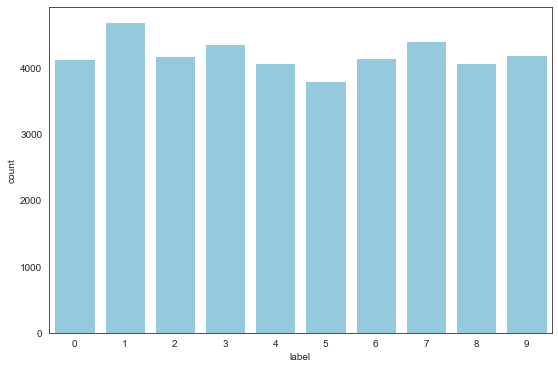

In [5]:
# segregate training data set in pixel features and label
y = data_set['label']
X = data_set.drop(labels = ['label'], axis=1) 
# free memory
del data_set

# check distribution of the handwritten digits
sns.countplot(y, color='skyblue');

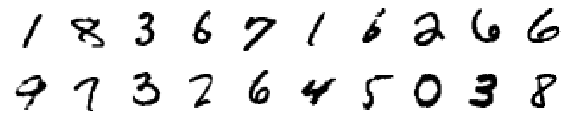

In [8]:
# show multiple images chosen randomly 
fig, axs = plt.subplots(2, 10, figsize=(10, 2)) # 2 rows of 10 images

for ax in axs.flat:
    i = randrange(X.shape[0])
    ax.imshow(X.loc[i].values.reshape(28, 28), cmap='gray_r')
    ax.set_axis_off()

In [9]:
# Normalize pixel value to range 0 to 1
X = X / 255.0

# extract train and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10)

## 1. Implementing a simple MLP

In [10]:
# define model
mlp = Sequential([
  Dense(128, activation='relu', input_shape=(784,)),  # change layer size from 64 to 128
  Dense(64, activation='sigmoid'), # change activation function from relu to sigmoid  
  Dense(10, activation='softmax'),
])

mlp.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

mlp.summary()






_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


Results after training the model:
* the accuracy on the validation set is around 0.975
* there is clear sign of overfitting as the loss for the validation set (around 0.090) is significantly higher than the loss on the training set (around 0.015)

In [11]:
# Train the model
n_epochs = 15 

#define callbacks
early_stop = EarlyStopping(monitor = 'val_acc', mode = 'max', patience=2)

history = mlp.fit(
    X_train,
    to_categorical(y_train),
    epochs = n_epochs,  
    validation_data = (X_val, to_categorical(y_val)),
    batch_size = 32,
    callbacks = [early_stop]
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 37800 samples, validate on 4200 samples
Epoch 1/15
37800/37800 [==============================] - 30s 802us/step - loss: 0.4091 - acc: 0.8922 - val_loss: 0.1902 - val_acc: 0.9455
Epoch 2/15
37800/37800 [==============================] - 21s 563us/step - loss: 0.1523 - acc: 0.9553 - val_loss: 0.1371 - val_acc: 0.9595
Epoch 3/15
37800/37800 [==============================] - 22s 589us/step - loss: 0.0996 - acc: 0.9711 - val_loss: 0.1066 - val_acc: 0.9669
Epoch 4/15
37800/37800 [==============================] - 22s 569us/step - loss: 0.0724 - acc: 0.9782 - val_loss: 0.0959 - val_acc: 0.9700
Epoch 5/15
37800/37800 [==============================] - 22s 574us/step - loss: 0.0530 - acc: 0.9844 - val_loss: 0.0828 - val_acc: 0.9717
Epoch 6/15
37800/37800 [==============================] - 22s 593us/step - loss: 0.0396 - acc: 0.9883 - val_loss: 0.0930 - val_acc: 0.9719
Epoch 7/15
37800/37800

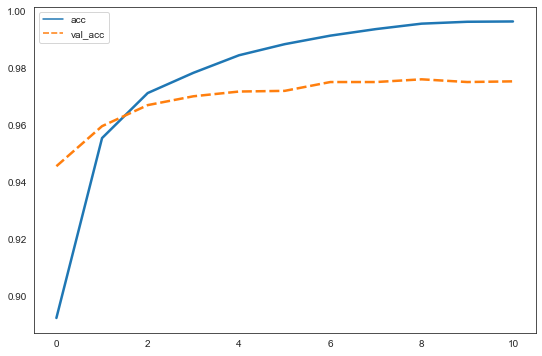

In [12]:
# load history in dataframe and plot accuracy of training and validation data
df_history = pd.DataFrame(history.history)
sns.lineplot(data=df_history[['acc','val_acc']], palette="tab10", linewidth=2.5);

## 2. Add dropout to reduce overfit
Our MLP model showed signs of overfitè we are now adding dropout to reduce the overfit.  
Results are:
* no more overfit from dropout rate = 0.2 and above 
* no or minimal improvement of the accuracy on the validation set: **we are reaching the limit of a simple MLP model**
* noticeable degradation of results (both on training and validation sets) for rate of 0.4 and above 

In [25]:
n_epochs = 15 

# empty lists to store models
models = []
# create empty dataframe to store history resukts
df_history = pd.DataFrame() 

for dropout in [i/10 for i in range(6)]:
    mlp = Sequential([
        Dense(128, activation='relu', input_shape=(784,)),  
        Dropout(rate=dropout),
        Dense(64, activation='sigmoid'), 
        Dropout(rate=dropout),    
        Dense(10, activation='softmax'),
        ])
    # add the new model to the list of models
    models.append(mlp)
    
    mlp.compile( 
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'],
        )

    print('Fit model, dropout rate = {:.2f}'.format(dropout))
    history = mlp.fit(
        X_train,
        to_categorical(y_train),
        epochs = n_epochs,  
        validation_data = (X_val, to_categorical(y_val)),
        batch_size = 32,
        callbacks = [early_stop]
        )
    
    # load history in dataframe and plot accuracy of training and validation data
    df = pd.DataFrame(history.history)
    df['epoch'] = [i+1 for i in range(df.shape[0])]
    df['dropout'] = dropout
    df_history = pd.concat([df_history, df], axis=0, sort=False)
    
    

Fit model, dropout rate = 0.00
Train on 37800 samples, validate on 4200 samples
Epoch 1/15
37800/37800 [==============================] - 43s 1ms/step - loss: 0.4017 - acc: 0.8966 - val_loss: 0.1798 - val_acc: 0.9479
Epoch 2/15
37800/37800 [==============================] - 23s 607us/step - loss: 0.1486 - acc: 0.9561 - val_loss: 0.1346 - val_acc: 0.9598
Epoch 3/15
37800/37800 [==============================] - 24s 630us/step - loss: 0.0988 - acc: 0.9712 - val_loss: 0.1133 - val_acc: 0.9674
Epoch 4/15
37800/37800 [==============================] - 23s 619us/step - loss: 0.0727 - acc: 0.9789 - val_loss: 0.0970 - val_acc: 0.9714
Epoch 5/15
37800/37800 [==============================] - 25s 664us/step - loss: 0.0542 - acc: 0.9841 - val_loss: 0.0883 - val_acc: 0.9717
Epoch 6/15
37800/37800 [==============================] - 24s 643us/step - loss: 0.0416 - acc: 0.9877 - val_loss: 0.0857 - val_acc: 0.9752
Epoch 7/15
37800/37800 [==============================] - 24s 641us/step - loss: 0.0323 

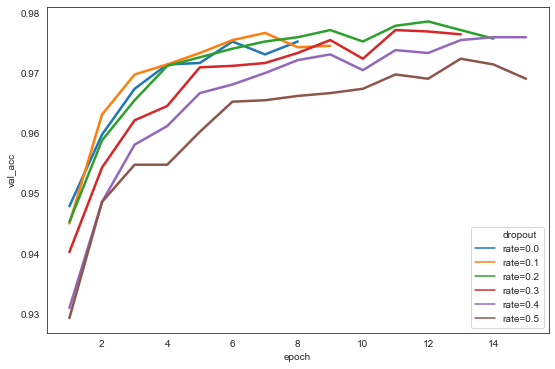

In [26]:
# issue in seaborn when hue has numbers formatted as string - https://github.com/mwaskom/seaborn/issues/1515
df_history['dropout'] = 'rate=' + df_history['dropout'].astype(str)
sns.lineplot(x='epoch', y='val_acc', hue='dropout', data=df_history[['epoch','val_acc','dropout']], palette="tab10", linewidth=2.5);

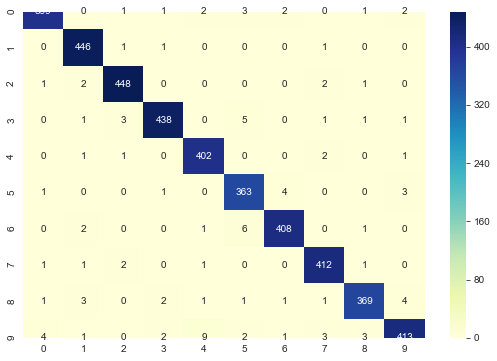

In [27]:
# reload best model, dropout rate = 0.2
mlp = models[2]

# get prediction on full dataset 
y_pred = mlp.predict(X_val)
y_pred = np.argmax(y_pred,axis=1)

confusion_mtx = confusion_matrix(y_val, y_pred)
sns.heatmap(data=confusion_mtx, annot=True, fmt='d', cmap='YlGnBu');

In [28]:
# save weights
mlp.save_weights('./output/mnist_mlp_dropout.h5')

# load test data
test = pd.read_csv('./input/test.csv')

# prediction
y_test = mlp.predict(test)

In [29]:
# convert to df
submission = pd.DataFrame(data=y_test)

# set label as the 0-9 class with highest value 
submission['Label'] = submission.idxmax(axis=1)
submission['ImageId'] = np.asarray([i+1 for i in range(submission.shape[0])])

submission.to_csv('./output/submission-mlp_dropout.csv', 
                  columns=['ImageId','Label'],
                  header=True,
                  index=False)

In [33]:
# free memory
del models

## 3. Implementing a simple CNN
We implement now a simple CNN since MLP model is limited at 0.975 accuracy. But tis doesnot show significant improvement over the MLP. It looks like this CNN is too simple.

In [47]:
# Reshape the images
img_size = 28
X_cnn = X.values.reshape(-1, img_size, img_size, 1)
# check 
print(X_cnn.shape)

X_train, X_val, y_train, y_val = train_test_split(X_cnn, y, test_size=0.1)

(42000, 28, 28, 1)


In [48]:
# define model
num_filters = 32
filter_size = 3
pool_size = 2

cnn = Sequential([
  Conv2D(num_filters, filter_size, input_shape=(28, 28, 1)),
  MaxPooling2D(pool_size=pool_size),
  Flatten(),      
  Dense(10, activation='softmax'),
])

cnn.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_51 (Dense)             (None, 10)                54090     
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
_________________________________________________________________


In [49]:
# Train the model
n_epochs = 15

history = cnn.fit(
    X_train,
    to_categorical(y_train),
    epochs=n_epochs,  
    validation_data=(X_val, to_categorical(y_val)), 
    batch_size=64,
    callbacks = [early_stop]
)

Train on 37800 samples, validate on 4200 samples
Epoch 1/15
37800/37800 [==============================] - 107s 3ms/step - loss: 0.3766 - acc: 0.8922 - val_loss: 0.2172 - val_acc: 0.9386
Epoch 2/15
37800/37800 [==============================] - 86s 2ms/step - loss: 0.1864 - acc: 0.9478 - val_loss: 0.1548 - val_acc: 0.9576
Epoch 3/15
37800/37800 [==============================] - 92s 2ms/step - loss: 0.1287 - acc: 0.9637 - val_loss: 0.1242 - val_acc: 0.9671
Epoch 4/15
37800/37800 [==============================] - 94s 2ms/step - loss: 0.0978 - acc: 0.9722 - val_loss: 0.1154 - val_acc: 0.9686
Epoch 5/15
37800/37800 [==============================] - 92s 2ms/step - loss: 0.0793 - acc: 0.9774 - val_loss: 0.0952 - val_acc: 0.9712
Epoch 6/15
37800/37800 [==============================] - 91s 2ms/step - loss: 0.0678 - acc: 0.9800 - val_loss: 0.1028 - val_acc: 0.9712
Epoch 7/15
37800/37800 [==============================] - 92s 2ms/step - loss: 0.0585 - acc: 0.9826 - val_loss: 0.0955 - val_acc

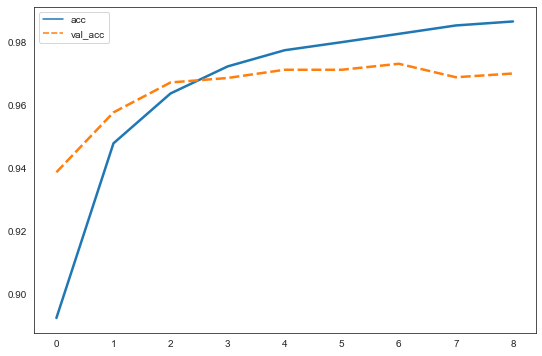

In [50]:
# load history in dataframe and plot accuracy for training and test data
df_history = pd.DataFrame(history.history)  
sns.lineplot(data=df_history[['acc','val_acc']], palette="tab10", linewidth=2.5);

### 4. Using a more complex CNN


In [55]:
num_filters = 32
filter_size = 3
pool_size = 2

cnn = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(64, activation='relu'),  # 128
    Dropout(0.5),
    Dense(10, activation='softmax')
])

cnn.compile(
  optimizer='adam',
  loss='categorical_crossentropy',  
  metrics=['accuracy'],
)

cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_56 (Dense)             (None, 64)                589888    
_________________________________________________________________
dropout_34 (Dropout)         (None, 64)                0         
__________

In [56]:
# Train the model
n_epochs = 15

history = cnn.fit(
    X_train,
    to_categorical(y_train),
    epochs=n_epochs,  
    validation_data=(X_val, to_categorical(y_val)), 
    batch_size=64,
    callbacks = [early_stop]
)

Train on 37800 samples, validate on 4200 samples
Epoch 1/15
37800/37800 [==============================] - 623s 16ms/step - loss: 0.3881 - acc: 0.8808 - val_loss: 0.0967 - val_acc: 0.9714
Epoch 2/15
37800/37800 [==============================] - 574s 15ms/step - loss: 0.1519 - acc: 0.9552 - val_loss: 0.0775 - val_acc: 0.9798
Epoch 3/15
37800/37800 [==============================] - 573s 15ms/step - loss: 0.1158 - acc: 0.9647 - val_loss: 0.0604 - val_acc: 0.9852
Epoch 4/15
37800/37800 [==============================] - 12414s 328ms/step - loss: 0.0925 - acc: 0.9719 - val_loss: 0.0630 - val_acc: 0.9840
Epoch 5/15
37800/37800 [==============================] - 602s 16ms/step - loss: 0.0797 - acc: 0.9753 - val_loss: 0.0607 - val_acc: 0.9843


In [64]:
cnn = Sequential([
    Conv2D(64, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1)),
#    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(64, activation='relu'),  
    Dropout(0.5),
    Dense(10, activation='softmax')
])

cnn.compile(
#  optimizer='adam',
  optimizer='adadelta',    
  loss='categorical_crossentropy',  
  metrics=['accuracy'],
)

cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 24, 24, 64)        1664      
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 22, 22, 32)        18464     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 11, 11, 32)        0         
_________________________________________________________________
dropout_41 (Dropout)         (None, 11, 11, 32)        0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 3872)              0         
_________________________________________________________________
dense_64 (Dense)             (None, 64)                247872    
_________________________________________________________________
dropout_42 (Dropout)         (None, 64)                0         
__________

In [65]:
n_epochs = 15

history = cnn.fit(
    X_train,
    to_categorical(y_train),
    epochs=n_epochs,  
    validation_data=(X_val, to_categorical(y_val)), 
    batch_size=64,
    callbacks = [early_stop]
)

Train on 37800 samples, validate on 4200 samples
Epoch 1/15
37800/37800 [==============================] - 754s 20ms/step - loss: 0.3618 - acc: 0.8852 - val_loss: 0.0931 - val_acc: 0.9717
Epoch 2/15
37800/37800 [==============================] - 572s 15ms/step - loss: 0.1428 - acc: 0.9570 - val_loss: 0.0787 - val_acc: 0.9783
Epoch 3/15
37800/37800 [==============================] - 570s 15ms/step - loss: 0.1120 - acc: 0.9680 - val_loss: 0.0607 - val_acc: 0.9838
Epoch 4/15
37800/37800 [==============================] - 569s 15ms/step - loss: 0.0908 - acc: 0.9727 - val_loss: 0.0605 - val_acc: 0.9836
Epoch 5/15
37800/37800 [==============================] - 570s 15ms/step - loss: 0.0798 - acc: 0.9770 - val_loss: 0.0559 - val_acc: 0.9852
Epoch 6/15
37800/37800 [==============================] - 571s 15ms/step - loss: 0.0741 - acc: 0.9781 - val_loss: 0.0565 - val_acc: 0.9869
Epoch 7/15
37800/37800 [==============================] - 572s 15ms/step - loss: 0.0686 - acc: 0.9800 - val_loss: 0.0

In [66]:
# save weights
cnn.save_weights('./output/mnist_cnn.h5')
test = pd.read_csv('./input/test.csv')

X_test = test.values.reshape(-1, img_size, img_size, 1)
y_test = cnn.predict(X_test)

# convert to df
submission = pd.DataFrame(data=y_test)

# set label as the 0-9 class with highest value 
submission['Label'] = submission.idxmax(axis=1)
submission['ImageId'] = np.asarray([i+1 for i in range(submission.shape[0])])

submission.to_csv('./output/submission-cnn.csv', 
                  columns=['ImageId','Label'],
                  header=True,
                  index=False)